In [1]:
#Imnporting libraries
import pandas as pd
import numpy as np
from scipy.optimize import fmin_slsqp
import os
import matplotlib.pyplot as plt

#Listing the existing files in the dir
for root, dirs, files in os.walk("."):  
    for filename in files:
        print(filename)

code.ipynb
index.html
COMMIT_EDITMSG
config
description
HEAD
index
applypatch-msg.sample
commit-msg.sample
fsmonitor-watchman.sample
post-update.sample
pre-applypatch.sample
pre-commit.sample
pre-push.sample
pre-rebase.sample
pre-receive.sample
prepare-commit-msg.sample
update.sample
exclude
HEAD
master
master
5108efed29355b7dc8d328cde74b1e98755c9a
f88d872b837c92b626f9cde570a42e7f36d38c
f318ffa38cc91f1286a42fe06fb9d64706808d
fe557a9d7fe3d267c5110019f3891a6fe652ab
cda8e721177be429e875da5b6c54d1f634833e
d97b9467177cdcac011907be76475a8c661163
8dc13db4f492af8daa95597fb199d2d6b411ec
b6eac46829b50005531cd378f4916c23278fd6
c1332e34dd9736a5f23a7cff7738cdeb81fb3f
bf6b84f253938597b2c29d19213e0443f62403
ecf7572746cbe4314b23d11bf3449fcc7d36f3
ff1eb5bc7d3d8f398a986aa34a649fe9e15aee
b752815fda2e17ae4d83f564cc5a035a60ab3b
9df40e4ae146d34b7773563240d9efdda9e13f
fa95aa9f0d9fd6db0813e2e8d422f0356291e2
cc70a1a5b034dad80cbb2e32c07d6f4dabdd5a
6dd04e8f3b8fa25c0f9a1f4c51e73104c15fa2
49ec1a8424948ef406e710626

In [2]:
#Loading df
df = pd.read_csv('./files/data-2018-09-24.csv')
df = df.drop(df.loc[:,['name', 'pft']].head(0).columns, axis=1)
inpt_df = df.iloc[:, 1:6]
inpt_arr = np.array(inpt_df)
outpt_df = df.iloc[:, 6:]
outpt_arr = np.array(outpt_df)
comp = np.array(df.iloc[:, 0])

In [3]:
#Calculating DEA
class DEA(object):

    def __init__(self, inputs, outputs):
        """
        Initialize the DEA object with input data
        n = number of entities (observations)
        m = number of inputs (variables, features)
        r = number of outputs
        :param inputs: inputs, n x m numpy array
        :param outputs: outputs, n x r numpy array
        :return: self
        """

        # supplied data
        self.inputs = inputs
        self.outputs = outputs

        # parameters
        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]

        # iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)

        # result arrays
        self.output_w = np.zeros((self.r, 1), dtype=np.float)  # output weights
        self.input_w = np.zeros((self.m, 1), dtype=np.float)  # input weights
        self.lambdas = np.zeros((self.n, 1), dtype=np.float)  # unit efficiencies
        self.efficiency = np.zeros_like(self.lambdas)  # thetas

        # names
        self.names = []

    def __efficiency(self, unit):
        """
        Efficiency function with already computed weights
        :param unit: which unit to compute for
        :return: efficiency
        """

        # compute efficiency
        denominator = np.dot(self.inputs, self.input_w)
        numerator = np.dot(self.outputs, self.output_w)

        return (numerator/denominator)[unit]

    def __target(self, x, unit):
        """
        Theta target function for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: theta
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        denominator = np.dot(self.inputs[unit], in_w)
        numerator = np.dot(self.outputs[unit], out_w)

        return numerator/denominator

    def __constraints(self, x, unit):
        """
        Constraints for optimization for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: array of constraints
        """

        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        constr = []  # init the constraint array

        # for each input, lambdas with inputs
        for input in self.input_:
            t = self.__target(x, unit)
            lhs = np.dot(self.inputs[:, input], lambdas)
            cons = t*self.inputs[unit, input] - lhs
            constr.append(cons)

        # for each output, lambdas with outputs
        for output in self.output_:
            lhs = np.dot(self.outputs[:, output], lambdas)
            cons = lhs - self.outputs[unit, output]
            constr.append(cons)

        # for each unit
        for u in self.unit_:
            constr.append(lambdas[u])

        return np.array(constr)

    def __optimize(self):
        """
        Optimization of the DEA model
        Use: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.linprog.html
        A = coefficients in the constraints
        b = rhs of constraints
        c = coefficients of the target function
        :return:
        """
        d0 = self.m + self.r + self.n
        # iterate over units
        for unit in self.unit_:
            # weights
            x0 = np.random.rand(d0) - 0.5
            x0 = fmin_slsqp(self.__target, x0, f_ieqcons=self.__constraints, args=(unit,))
            # unroll weights
            self.input_w, self.output_w, self.lambdas = x0[:self.m], x0[self.m:(self.m+self.r)], x0[(self.m+self.r):]
            self.efficiency[unit] = self.__efficiency(unit)

    def name_units(self, names):
        """
        Provide names for units for presentation purposes
        :param names: a list of names, equal in length to the number of units
        :return: nothing
        """

        assert(self.n == len(names))

        self.names = names

    def fit(self):
        """
        Optimize the dataset, generate basic table
        :return: table
        """

        self.__optimize()  # optimize

        print("Final thetas for each unit:\n")
        print("---------------------------\n")
        for n, eff in enumerate(self.efficiency):
            if len(self.names) > 0:
                name = "Unit %s" % self.names[n]
            else:
                name = "Unit %d" % (n+1)
            print("%s theta: %.4f" % (name, eff))
            print("\n")
        print("---------------------------\n")

dea = DEA(inpt_arr,outpt_arr)
dea.name_units(comp)
dea.fit()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.919745490191
            Iterations: 13
            Function evaluations: 1041
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.900793061728
            Iterations: 18
            Function evaluations: 1440
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.926755256088
            Iterations: 19
            Function evaluations: 1520
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.893308782937
            Iterations: 15
            Function evaluations: 1201
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.929485436919
            Iterations: 7
            Function evaluations

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.941628042979
            Iterations: 21
            Function evaluations: 1681
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.947353218184
            Iterations: 11
            Function evaluations: 880
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.864229113034
            Iterations: 13
            Function evaluations: 1040
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000049
            Iterations: 9
            Function evaluations: 720
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.88022059753
            Iterations: 7
            Function evaluations: 560
 

In [4]:
#Calculation efficiency by dividing output by input to be used for the graph
frst = outpt_df.div(inpt_df.x1, axis = 0)
frst.columns = ['y1-x1', 'y2-x1', 'y3-x1']
sec = outpt_df.div(inpt_df.x2, axis = 0)
sec.columns = ['y1-x2', 'y2-x2', 'y3-x2']
th = outpt_df.div(inpt_df.x3, axis = 0)
th.columns = ['y1-x3', 'y2-x3', 'y3-x3']
fo = outpt_df.div(inpt_df.x4, axis = 0)
fo.columns = ['y1-x4', 'y2-x4', 'y3-x4']
fi = outpt_df.div(inpt_df.x5, axis = 0)
fi.columns = ['y1-x5', 'y2-x5', 'y3-x5']
complete = pd.DataFrame(df.iloc[:,0]).join(frst).join(sec).join(th).join(fo).join(fi)

Index([u'firm', u'y1-x1', u'y2-x1', u'y3-x1', u'y1-x2', u'y2-x2', u'y3-x2',
       u'y1-x3', u'y2-x3', u'y3-x3', u'y1-x4', u'y2-x4', u'y3-x4', u'y1-x5',
       u'y2-x5', u'y3-x5'],
      dtype='object')

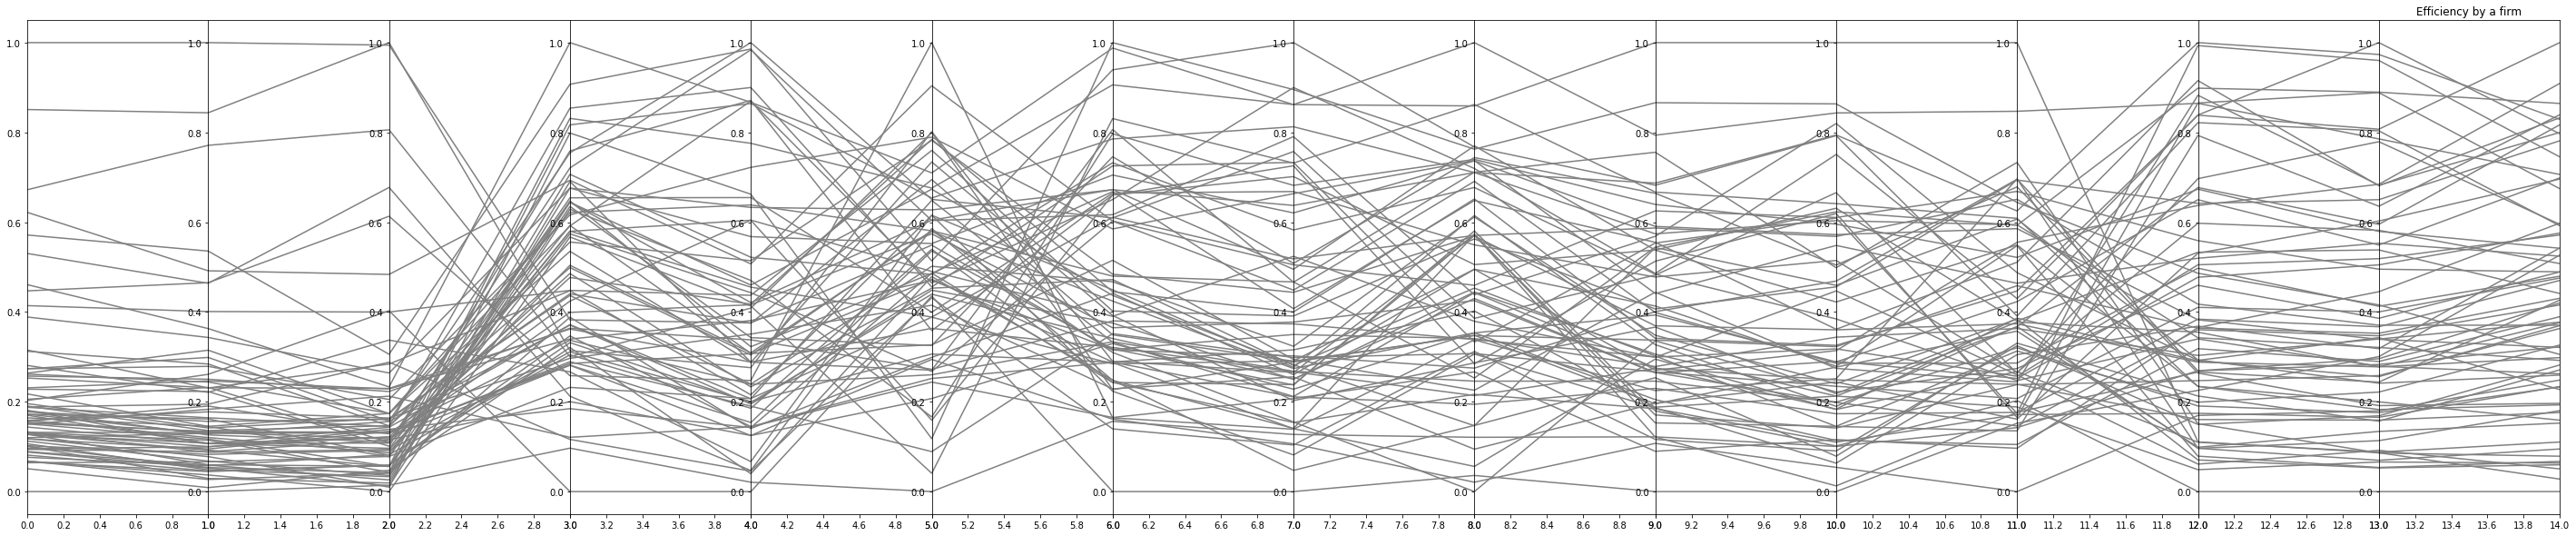

In [6]:
#Building a graph
eff = ['y1-x1', 'y2-x1', 'y3-x1', 'y1-x2', 'y2-x2', 'y3-x2',
       'y1-x3', 'y2-x3', 'y3-x3', 'y1-x4', 'y2-x4', 'y3-x4', 'y1-x5',
       'y2-x5', 'y3-x5']
x = [i for i, _ in enumerate(eff)]

min_max_range = {}
for e in eff:
    min_max_range[e] = [complete[e].min(), complete[e].max(), np.ptp(complete[e])]
    complete[e] = np.true_divide(complete[e] - complete[e].min(), np.ptp(complete[e]))
    
fig, axes = plt.subplots(1, len(x)-1, sharey = False, figsize = (50,10), gridspec_kw = {'wspace':0, 'hspace':0})    

# Plot each row
for i, ax in enumerate(axes):
    for idx in complete.index:
        ax.plot(x, complete.loc[idx, eff], color='gray')  
    ax.set_xlim([x[i], x[i+1]])

plt.title("Efficiency by a firm")
plt.show()

In [ ]:
complete.to_csv('./files/output.csv')